In [12]:
# Cell 1
import os
import joblib
import numpy as np
import pandas as pd
import torch
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# d3rlpy (older API)
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [13]:
# Cell 2
DATA_DIR = os.path.join("..","data")
MODELS_DIR = os.path.join("..","models")
os.makedirs(MODELS_DIR, exist_ok=True)

# Load X, y
X_path = os.path.join(DATA_DIR, "X_preprocessed.joblib")
y_path = os.path.join(DATA_DIR, "y_preprocessed.joblib")
df_encoded_path = os.path.join(DATA_DIR, "df_encoded.joblib")

assert os.path.exists(X_path), f"Missing {X_path}"
assert os.path.exists(y_path), f"Missing {y_path}"
assert os.path.exists(df_encoded_path), f"Missing {df_encoded_path} — run Task1 save cell to create it."

X = joblib.load(X_path)
y = joblib.load(y_path)
df_encoded = joblib.load(df_encoded_path)

print("Loaded shapes -> X:", X.shape, "y:", y.shape, "df_encoded:", df_encoded.shape)
gc.collect()


Loaded shapes -> X: (1345310, 84) y: (1345310,) df_encoded: (1345310, 85)


2692151

In [14]:
# Cell 3
RND = 42
n = X.shape[0]
idx = np.arange(n)

trainval_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=RND)
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.1, stratify=y[trainval_idx], random_state=RND)

print("Splits sizes -> train:", train_idx.size, "val:", val_idx.size, "test:", test_idx.size)


Splits sizes -> train: 968623 val: 107625 test: 269062


In [15]:
# Cell 4A (Option A) — quick sample-based scaler
sample_size = 100_000  # lower if you have less RAM (50k, 20k)
rng = np.random.default_rng(RND)
if train_idx.size > sample_size:
    sample_idx = rng.choice(train_idx, size=sample_size, replace=False)
else:
    sample_idx = train_idx

print("Fitting StandardScaler on sample size:", sample_idx.size)
scaler = StandardScaler()
scaler.fit(X[sample_idx])

# Transform test/val/train in batches to avoid spikes
def transform_in_batches(X_in, scaler, batch=65536):
    nrows = X_in.shape[0]
    out = np.empty((nrows, X_in.shape[1]), dtype=np.float32)
    for i in range(0, nrows, batch):
        j = min(i+batch, nrows)
        out[i:j] = scaler.transform(X_in[i:j]).astype(np.float32)
    return out

X_train_s = transform_in_batches(X[train_idx], scaler)
X_val_s   = transform_in_batches(X[val_idx], scaler)
X_test_s  = transform_in_batches(X[test_idx], scaler)

# save scaler
joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler_sampled.joblib"))
print("Scaled arrays shapes (train/val/test):", X_train_s.shape, X_val_s.shape, X_test_s.shape)
gc.collect()


Fitting StandardScaler on sample size: 100000
Scaled arrays shapes (train/val/test): (968623, 84) (107625, 84) (269062, 84)


0

In [16]:
for col in ["loan_amnt","int_rate","target"]:
    if col not in df_encoded.columns:
        raise KeyError(f"Required column '{col}' missing from df_encoded")

loan_amnt = df_encoded["loan_amnt"].values.astype(np.float32)
int_rate = df_encoded["int_rate"].values.astype(np.float32)
targets = df_encoded["target"].values.astype(int)

# reward per assignment
rewards = np.where(targets == 0, loan_amnt * int_rate, -loan_amnt).astype(np.float32)
print("Rewards computed. sample:", rewards[:5], "mean:", rewards.mean(), "min:", rewards.min())


Rewards computed. sample: [ 503.63998 2961.53    2156.      2334.8     1606.08   ] mean: -1644.7538 min: -40000.0


In [17]:
# Cell 6
observations = X.astype(np.float32)   # full observations used to build dataset
actions = np.ones((observations.shape[0],), dtype=np.int32)  # history = approved
terminals = np.ones((observations.shape[0],), dtype=np.bool_)  # single-step episodes
rewards_rl = rewards

dataset = MDPDataset(observations, actions, rewards_rl, terminals)
print("MDPDataset created. #episodes:", len(dataset.episodes))
ep0 = dataset.episodes[0]
print("Episode[0] shapes -> obs:", ep0.observations.shape, "actions:", ep0.actions.shape, "rewards:", ep0.rewards.shape)


2025-12-12 14:24.44 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(84,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-12 14:24.44 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-12 14:24.49 [info     ] Action size has been automatically determined. action_size=2
MDPDataset created. #episodes: 1345310
Episode[0] shapes -> obs: (1, 84) actions: (1, 1) rewards: (1, 1)


In [23]:
# Cell 7 (updated) — instantiate and train a DISCRETE offline RL algo compatible with old d3rlpy

import os, traceback
from importlib import import_module

# choose n_steps small for quick test, increase later
n_steps = 100_000  

# try to detect whether dataset is discrete
is_discrete = None
try:
    from d3rlpy.dataset import ActionSpace
    is_discrete = (hasattr(dataset, "action_space") and dataset.action_space == ActionSpace.DISCRETE)
except Exception:
    try:
        # older API: check action size if present
        a_size = getattr(dataset, "action_size", None)
        if a_size is None:
            # try reading the automatic log info if available
            is_discrete = True  # default to discrete since our actions are ints (0/1)
        else:
            is_discrete = (a_size == 2)  # 2 discrete actions (deny/approve)
    except Exception:
        is_discrete = True

print("Detected discrete action space?:", is_discrete)

# device string expected by this d3rlpy version
device_name = "cuda" if torch.cuda.is_available() else "cpu"

trained_algo = None
save_path = os.path.join(MODELS_DIR, "cql_policy_discrete")

# Try a few likely constructors for discrete CQL (older API)
try:
    # Preferred: DiscreteCQLConfig -> create
    try:
        from d3rlpy.algos import DiscreteCQLConfig, DiscreteCQL
        print("Found DiscreteCQLConfig + DiscreteCQL in d3rlpy.")
        cfg = DiscreteCQLConfig()
        # many old versions have a create() helper
        try:
            algo = cfg.create(device=device_name)
            print("Instantiated algo via DiscreteCQLConfig().create(device).")
        except Exception:
            # fallback to DiscreteCQL(cfg, device, enable_ddp)
            algo = DiscreteCQL(cfg, device_name, False)
            print("Instantiated DiscreteCQL(cfg, device, False).")
        trained_algo = algo
    except Exception as e1:
        # Try importing DiscreteCQL directly
        try:
            from d3rlpy.algos import DiscreteCQL
            print("Found DiscreteCQL directly.")
            # old signature requires (config, device, enable_ddp) — try default config if needed
            try:
                cfg = None
                try:
                    # try to get a default config class
                    from d3rlpy.algos import DiscreteCQLConfig as DCC
                    cfg = DCC()
                except Exception:
                    pass
                if cfg is not None:
                    algo = DiscreteCQL(cfg, device_name, False)
                else:
                    # some versions allow DiscreteCQL(device=...) — try fallback
                    try:
                        algo = DiscreteCQL(device_name)
                    except Exception:
                        algo = DiscreteCQL(cfg, device_name, False)
                trained_algo = algo
                print("Instantiated DiscreteCQL via fallback.")
            except Exception as e2:
                print("Failed to instantiate DiscreteCQL directly:", e2)
                raise
        except Exception as e3:
            print("DiscreteCQL not found; will try alternative discrete algorithms (e.g., DiscreteBCQ).")
            # try DiscreteBCQ as fallback
            try:
                from d3rlpy.algos import DiscreteBCQ
                print("Found DiscreteBCQ; using it as fallback.")
                try:
                    cfg = None
                    from d3rlpy.algos import DiscreteBCQConfig as DBC
                    cfg = DBC()
                    algo = DiscreteBCQ(cfg, device_name, False)
                except Exception:
                    algo = DiscreteBCQ(device_name)
                trained_algo = algo
            except Exception:
                print("No discrete CQL/BCQ available. See error below.")
                raise

    # If we got here, trained_algo is the instantiated algo
    print("Algo instantiated. Now calling fit(dataset, n_steps)...")
    # older API expects fit(dataset, n_steps)
    try:
        trained_algo.fit(dataset, n_steps)
    except TypeError as e_fit:
        # try alternate positional signatures
        try:
            # some versions expect (dataset, n_steps, n_steps_per_epoch)
            trained_algo.fit(dataset, n_steps, None)
        except Exception:
            print("Fit failed with TypeError:", e_fit)
            raise

    print("Training finished successfully.")
    # Save
    try:
        trained_algo.save_model(save_path)
        print("Saved discrete policy to:", save_path)
    except Exception as e_save:
        print("Could not auto-save model; but training succeeded. Save manually later. Error:", e_save)

except Exception as final_e:
    print("Failed to instantiate & train a discrete CQL variant. Full traceback:")
    traceback.print_exc()
    print("\nPlease paste the above traceback here and I'll provide the exact call for your d3rlpy build.")


Detected discrete action space?: True
Found DiscreteCQLConfig + DiscreteCQL in d3rlpy.
Instantiated algo via DiscreteCQLConfig().create(device).
Algo instantiated. Now calling fit(dataset, n_steps)...
2025-12-12 14:30.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(84,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-12-12 14:30.26 [debug    ] Building models...            
2025-12-12 14:30.26 [debug    ] Models have been built.       
2025-12-12 14:30.26 [info     ] Directory is created at d3rlpy_logs\DiscreteCQL_20251212143026
2025-12-12 14:30.26 [info     ] Parameters                     params={'observation_shape': [84], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': '

Epoch 1/10: 100%|██████████| 10000/10000 [01:00<00:00, 165.05it/s, loss=3.9e+3, td_loss=3.9e+3, conservative_loss=0.167] 


2025-12-12 14:31.27 [info     ] DiscreteCQL_20251212143026: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001280496835708618, 'time_algorithm_update': 0.004418916654586792, 'loss': 3903.5017520080564, 'td_loss': 3903.3346121643067, 'conservative_loss': 0.16713982580006123, 'time_step': 0.005983163785934448} step=10000
2025-12-12 14:31.27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_10000.d3


Epoch 2/10: 100%|██████████| 10000/10000 [00:54<00:00, 184.27it/s, loss=3.88e+3, td_loss=3.88e+3, conservative_loss=0]


2025-12-12 14:32.21 [info     ] DiscreteCQL_20251212143026: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0009119076251983642, 'time_algorithm_update': 0.004167634844779968, 'loss': 3878.4320036346435, 'td_loss': 3878.4320036346435, 'conservative_loss': 0.0, 'time_step': 0.005355963850021362} step=20000
2025-12-12 14:32.21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_20000.d3


Epoch 3/10: 100%|██████████| 10000/10000 [00:54<00:00, 185.18it/s, loss=3.89e+3, td_loss=3.89e+3, conservative_loss=0.0071]


2025-12-12 14:33.15 [info     ] DiscreteCQL_20251212143026: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0009252127647399902, 'time_algorithm_update': 0.004114203953742981, 'loss': 3889.661686169434, 'td_loss': 3889.654591442871, 'conservative_loss': 0.00709471435546875, 'time_step': 0.0053227769613265995} step=30000
2025-12-12 14:33.15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_30000.d3


Epoch 4/10: 100%|██████████| 10000/10000 [00:54<00:00, 184.31it/s, loss=3.89e+3, td_loss=3.89e+3, conservative_loss=0]


2025-12-12 14:34.10 [info     ] DiscreteCQL_20251212143026: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0009305177688598633, 'time_algorithm_update': 0.00411879985332489, 'loss': 3886.5600315582274, 'td_loss': 3886.5600315582274, 'conservative_loss': 0.0, 'time_step': 0.005358664870262146} step=40000
2025-12-12 14:34.10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_40000.d3


Epoch 5/10: 100%|██████████| 10000/10000 [00:54<00:00, 182.23it/s, loss=3.89e+3, td_loss=3.89e+3, conservative_loss=0]


2025-12-12 14:35.05 [info     ] DiscreteCQL_20251212143026: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.0009438675403594971, 'time_algorithm_update': 0.004161187195777893, 'loss': 3893.8108352111817, 'td_loss': 3893.8108352111817, 'conservative_loss': 0.0, 'time_step': 0.005409977269172668} step=50000
2025-12-12 14:35.05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_50000.d3


Epoch 6/10: 100%|██████████| 10000/10000 [00:57<00:00, 172.68it/s, loss=3.89e+3, td_loss=3.89e+3, conservative_loss=0]


2025-12-12 14:36.02 [info     ] DiscreteCQL_20251212143026: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.0010060785293579102, 'time_algorithm_update': 0.004408672285079956, 'loss': 3886.0329872375487, 'td_loss': 3886.0329872375487, 'conservative_loss': 0.0, 'time_step': 0.00571550714969635} step=60000
2025-12-12 14:36.03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_60000.d3


Epoch 7/10: 100%|██████████| 10000/10000 [00:53<00:00, 185.30it/s, loss=3.88e+3, td_loss=3.88e+3, conservative_loss=0]


2025-12-12 14:36.56 [info     ] DiscreteCQL_20251212143026: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.0008993242025375366, 'time_algorithm_update': 0.004133982682228089, 'loss': 3884.877234524536, 'td_loss': 3884.877234524536, 'conservative_loss': 0.0, 'time_step': 0.0053268884658813475} step=70000
2025-12-12 14:36.57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_70000.d3


Epoch 8/10: 100%|██████████| 10000/10000 [00:54<00:00, 183.49it/s, loss=3.9e+3, td_loss=3.9e+3, conservative_loss=0.00413] 


2025-12-12 14:37.51 [info     ] DiscreteCQL_20251212143026: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.0009059104681015015, 'time_algorithm_update': 0.004164836883544922, 'loss': 3899.59557053833, 'td_loss': 3899.5914432922364, 'conservative_loss': 0.004127241516113281, 'time_step': 0.005381547713279724} step=80000
2025-12-12 14:37.51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_80000.d3


Epoch 9/10: 100%|██████████| 10000/10000 [00:55<00:00, 181.19it/s, loss=3.89e+3, td_loss=3.89e+3, conservative_loss=0]


2025-12-12 14:38.46 [info     ] DiscreteCQL_20251212143026: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.0009174440145492554, 'time_algorithm_update': 0.004230269908905029, 'loss': 3887.9616656188964, 'td_loss': 3887.9616656188964, 'conservative_loss': 0.0, 'time_step': 0.005443122124671936} step=90000
2025-12-12 14:38.46 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_90000.d3


Epoch 10/10: 100%|██████████| 10000/10000 [00:54<00:00, 183.10it/s, loss=3.88e+3, td_loss=3.88e+3, conservative_loss=0]


2025-12-12 14:39.41 [info     ] DiscreteCQL_20251212143026: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.0009169990301132202, 'time_algorithm_update': 0.004171046662330627, 'loss': 3881.209296218872, 'td_loss': 3881.209296218872, 'conservative_loss': 0.0, 'time_step': 0.005385436940193176} step=100000
2025-12-12 14:39.41 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20251212143026\model_100000.d3
Training finished successfully.
Saved discrete policy to: ..\models\cql_policy_discrete


In [25]:
# Cell 8: Predict RL actions on test set and compute RL policy value

import numpy as np
import joblib, os

# Ensure we have test_idx / X_test_s / y_test available; recreate splits if needed
if 'test_idx' not in globals() or 'y_test' not in globals():
    from sklearn.model_selection import train_test_split
    RND = 42
    idx = np.arange(X.shape[0])
    trainval_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=RND)
    train_idx, val_idx = train_test_split(trainval_idx, test_size=0.1, stratify=y[trainval_idx], random_state=RND)
    y_test = y[test_idx]
    print("Recreated test_idx and y_test.")

# Ensure X_test_s exists (from Option A/B); if not, try to scale small sample quick
if 'X_test_s' not in globals():
    if 'scaler' in globals():
        X_test_s = scaler.transform(X[test_idx]).astype(np.float32)
        print("Created X_test_s from existing scaler.")
    else:
        # fallback: do a quick StandardScaler on a sample (fast)
        from sklearn.preprocessing import StandardScaler
        quick_scaler = StandardScaler()
        sample_idx = train_idx if 'train_idx' in globals() else np.random.choice(np.arange(X.shape[0]), size=min(100000, X.shape[0]), replace=False)
        quick_scaler.fit(X[sample_idx])
        X_test_s = quick_scaler.transform(X[test_idx]).astype(np.float32)
        print("Quick-fitted scaler and created X_test_s.")

# Find trained RL algo object
algo = None
if 'trained_algo' in globals():
    algo = trained_algo
elif 'cql' in globals():
    algo = cql
elif 'algo' in globals():
    algo = algo
else:
    raise RuntimeError("Trained RL algorithm object not found. Expected 'trained_algo' or 'cql' in globals.")

print("Using RL object:", algo.__class__.__name__)

# Robust prediction (try few options)
try:
    rl_actions = algo.predict(X_test_s)
except Exception as e1:
    try:
        rl_actions = algo.predict(X[test_idx])
    except Exception as e2:
        # try batch-wise prediction if available
        try:
            rl_actions = []
            for i in range(0, X_test_s.shape[0], 65536):
                batch = X_test_s[i:i+65536]
                rl_actions.extend(list(algo.predict(batch)))
            rl_actions = np.array(rl_actions)
        except Exception as e3:
            raise RuntimeError(f"All algo.predict attempts failed: {e1}\n{e2}\n{e3}")

rl_actions = np.array(rl_actions).astype(int).ravel()
print("RL actions predicted. sample:", rl_actions[:20], "approve rate:", rl_actions.mean()*100, "%")

# Compute RL rewards using df_encoded loan_amnt and int_rate
loan_amnt = df_encoded['loan_amnt'].values.astype(np.float32)
int_rate = df_encoded['int_rate'].values.astype(np.float32)

loan_amnt_test = loan_amnt[test_idx].astype(np.float32)
int_rate_test = int_rate[test_idx].astype(np.float32)

rl_rewards = np.where(
    rl_actions == 1,
    np.where(y_test == 0, loan_amnt_test * int_rate_test, -loan_amnt_test),
    0.0
).astype(np.float32)

rl_policy_value = float(np.mean(rl_rewards))
print("Estimated RL policy value (avg reward per applicant):", rl_policy_value)


Using RL object: DiscreteCQL
RL actions predicted. sample: [1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0] approve rate: 80.09938229850368 %
Estimated RL policy value (avg reward per applicant): -1604.3741455078125


In [29]:
# Cell 8.5 — Restore supervised model and recompute test_preds

import torch
import torch.nn as nn
import joblib
import os

# Ensure we have X_test_s and test_y/y_test
if 'X_test_s' not in globals():
    raise RuntimeError("X_test_s not found — rerun scaling from Task 1 or 3.")

# Load model (use best_mlp.pth based on your folder)
model_path = os.path.join("..", "models", "best_mlp.pth")
scaler_path = os.path.join("..", "models", "scaler.joblib")

assert os.path.exists(model_path), f"Supervised model file {model_path} not found."
assert os.path.exists(scaler_path), "Scaler not found — needed for consistency."

scaler = joblib.load(scaler_path)

# Rebuild the same model architecture as Task 2
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = MLP(X_test_s.shape[1])
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

print("Loaded supervised model from:", model_path)

# Convert X_test_s into tensor and predict
X_test_tensor = torch.from_numpy(X_test_s).float()
with torch.no_grad():
    test_preds = model(X_test_tensor).numpy().ravel()

print("Computed test_preds. Sample:", test_preds[:10])


Loaded supervised model from: ..\models\best_mlp.pth
Computed test_preds. Sample: [0.08781403 0.09751511 0.109252   0.11655045 0.22374232 0.17728013
 0.31947234 0.06535068 0.16046016 0.29505876]


In [30]:
# Cell 9: Compute supervised policy value (use best_thr if present) and simple baselines

# get best threshold from Task2 if available, else default to 0.23
best_thr = globals().get("best_thr", 0.23)
print("Using supervised threshold:", best_thr)

# ensure supervised predictions on test exist
if 'test_preds' not in globals():
    raise RuntimeError("test_preds (supervised probabilities for test) not found. Re-run Task2 evaluation cells to produce test_preds.")

sup_actions = (test_preds >= best_thr).astype(int).ravel()

sup_rewards = np.where(
    sup_actions == 1,
    np.where(y_test == 0, loan_amnt_test * int_rate_test, -loan_amnt_test),
    0.0
).astype(np.float32)
sup_policy_value = float(np.mean(sup_rewards))

# Baselines
approve_all_rewards = np.where(y_test == 0, loan_amnt_test * int_rate_test, -loan_amnt_test).astype(np.float32)
approve_all_value = float(np.mean(approve_all_rewards))
deny_all_value = 0.0

print("\nPolicy values (avg reward per applicant):")
print(f"  RL policy value:         {rl_policy_value:.6f}")
print(f"  Supervised policy value: {sup_policy_value:.6f}")
print(f"  Approve-all policy value:{approve_all_value:.6f}")
print(f"  Deny-all policy value:   {deny_all_value:.6f}")

print("\nApproval rates:")
print(f"  RL approves:         {rl_actions.mean()*100:.2f}%")
print(f"  Supervised approves: {sup_actions.mean()*100:.2f}%")
print("  Approve-all:         100.00%")
print("  Deny-all:            0.00%")


Using supervised threshold: 0.23

Policy values (avg reward per applicant):
  RL policy value:         -1604.374146
  Supervised policy value: -1395.719116
  Approve-all policy value:-1651.944458
  Deny-all policy value:   0.000000

Approval rates:
  RL approves:         80.10%
  Supervised approves: 35.38%
  Approve-all:         100.00%
  Deny-all:            0.00%


In [31]:
# Cell 10: Build comparison dataframe, show disagreements, and save

import pandas as pd

comparison_df = pd.DataFrame({
    "test_idx": test_idx,
    "prob_supervised": test_preds,
    "sup_action": sup_actions,
    "rl_action": rl_actions,
    "y": y_test,
    "loan_amnt": loan_amnt_test,
    "int_rate": int_rate_test,
    "rl_reward": rl_rewards,
    "sup_reward": sup_rewards
})

diffs = comparison_df[comparison_df["sup_action"] != comparison_df["rl_action"]].copy()
print("Total disagreements on test:", len(diffs))
display(diffs.head(10))

# Save results & top disagreements
os.makedirs(os.path.join("..","models"), exist_ok=True)
joblib.dump(comparison_df, os.path.join("..","models","rl_vs_supervised_comparison.joblib"))
diffs.head(100).to_csv(os.path.join("..","models","rl_supervised_disagreements_sample.csv"), index=False)
print("Saved comparison and sample disagreements to ../models/")


Total disagreements on test: 124916


,test_idx,prob_supervised,sup_action,rl_action,y,loan_amnt,int_rate,rl_reward,sup_reward
0,1311262,0.087814,0,1,0,15000.0,0.0799,1198.500000,0.00000
3,810959,0.116550,0,1,0,14000.0,0.1398,1957.199951,0.00000
4,1157129,0.223742,0,1,0,8575.0,0.1433,1228.797485,0.00000
5,31964,0.177280,0,1,1,20000.0,0.1199,-20000.000000,0.00000
7,869682,0.065351,0,1,0,8000.0,0.0967,773.599976,0.00000
8,1314407,0.160460,0,1,0,35000.0,0.1599,5596.500000,0.00000
9,803292,0.295059,1,0,0,14400.0,0.1167,0.000000,1680.47998
12,777538,0.192290,0,1,0,5400.0,0.1167,630.179993,0.00000
14,620960,0.098825,0,1,0,8000.0,0.0789,631.200012,0.00000
17,1083203,0.227189,0,1,0,4800.0,0.1588,762.240051,0.00000


Saved comparison and sample disagreements to ../models/


In [33]:
# Cell 11: Save summary artifacts and (optional) compute bootstrap CI for policy values

results = {
    "rl_policy_value": rl_policy_value,
    "supervised_policy_value": sup_policy_value,
    "approve_all_value": approve_all_value,
    "deny_all_value": deny_all_value,
    "rl_approve_rate": float(rl_actions.mean()),
    "supervised_approve_rate": float(sup_actions.mean()),
    "best_threshold": float(best_thr)
}
joblib.dump(results, os.path.join("..","models","policy_values_summary.joblib"))
print("Saved policy summary to ../models/policy_values_summary.joblib")

# Optional: bootstrap 95% CI for RL and supervised policy values (may take some time)
def bootstrap_ci(values, n_boot=1000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(values)
    means = []
    for _ in range(n_boot):
        sample_idx = rng.integers(0, n, n)
        means.append(values[sample_idx].mean())
    lower = np.percentile(means, 100*alpha/2)
    upper = np.percentile(means, 100*(1-alpha/2))
    return lower, upper

# compute CIs on per-applicant rewards (uncomment if desired)
rl_lower, rl_upper = bootstrap_ci(rl_rewards, n_boot=200)
sup_lower, sup_upper = bootstrap_ci(sup_rewards, n_boot=200)
print(f"RL policy value 95% CI: [{rl_lower:.6f}, {rl_upper:.6f}]")
print(f"Supervised policy value 95% CI: [{sup_lower:.6f}, {sup_upper:.6f}]")


Saved policy summary to ../models/policy_values_summary.joblib
RL policy value 95% CI: [-1630.421509, -1576.974976]
Supervised policy value 95% CI: [-1416.862793, -1371.699097]


TASK --->> 4

In [36]:
# Task4_Cell1 - imports & helper functions
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.calibration import calibration_curve
import seaborn as sns
sns.set_style("whitegrid")

MODELS_DIR = os.path.join("..","models")
DATA_DIR = os.path.join("..","data")
os.makedirs(MODELS_DIR, exist_ok=True)

def require(varname):
    if varname not in globals():
        raise RuntimeError(f"Required variable '{varname}' not found in memory. Make sure Task 3 cells created it.")


In [37]:
# Task4_Cell2 - ensure required variables exist (created by Task 3)
required = ['test_idx','y_test','X_test_s','test_preds','rl_actions','rl_policy_value','sup_policy_value','loan_amnt','int_rate']
for v in required:
    if v not in globals():
        raise RuntimeError(f"Missing required variable: {v}. Re-run Task3 cells or restore artifacts (see earlier cells).")
print("All required variables present.")


All required variables present.


In [38]:
# Task4_Cell3 - core metrics
# supervised metrics
test_auc = roc_auc_score(y_test, test_preds)
f1_05 = f1_score(y_test, (test_preds>=0.5).astype(int))
best_thr = globals().get("best_thr", 0.23)
f1_best = f1_score(y_test, (test_preds>=best_thr).astype(int))

# policy values (from Task3 variables)
rl_val = float(rl_policy_value)
sup_val = float(sup_policy_value)

print("=== Supervised metrics ===")
print(f"AUC (test): {test_auc:.4f}")
print(f"F1 @ 0.5 (test): {f1_05:.4f}")
print(f"F1 @ best_thr={best_thr:.3f} (test): {f1_best:.4f}\n")

print("=== Policy values (avg reward per applicant) ===")
print(f"Supervised policy value: {sup_val:.4f}")
print(f"RL policy value:         {rl_val:.4f}")

# Save numeric summary
summary = {
    "test_auc": float(test_auc),
    "f1_05": float(f1_05),
    "best_thr": float(best_thr),
    "f1_best": float(f1_best),
    "supervised_policy_value": sup_val,
    "rl_policy_value": rl_val
}
joblib.dump(summary, os.path.join(MODELS_DIR,"task4_summary.joblib"))
print("\nSaved numeric summary to", os.path.join(MODELS_DIR,"task4_summary.joblib"))


=== Supervised metrics ===
AUC (test): 0.7175
F1 @ 0.5 (test): 0.1428
F1 @ best_thr=0.230 (test): 0.4343

=== Policy values (avg reward per applicant) ===
Supervised policy value: -1395.7191
RL policy value:         -1604.3741

Saved numeric summary to ..\models\task4_summary.joblib


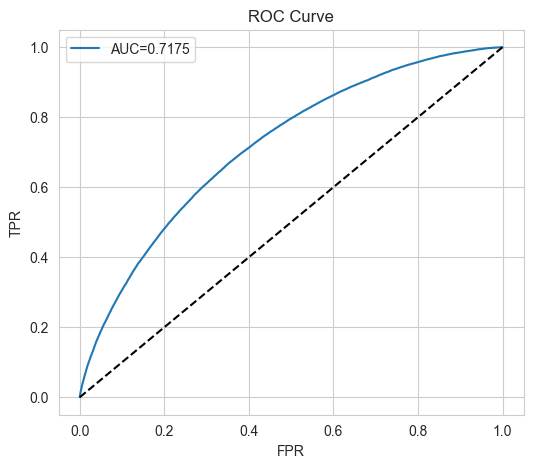

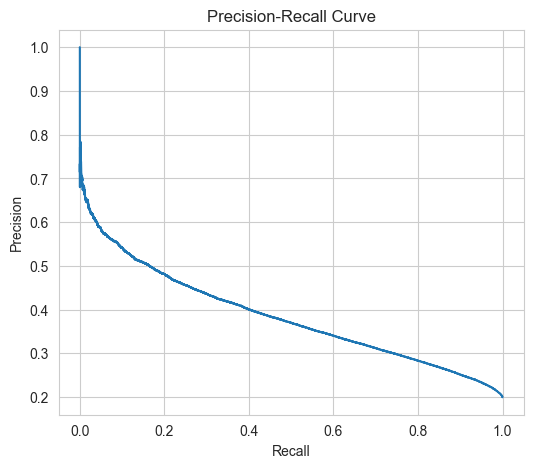

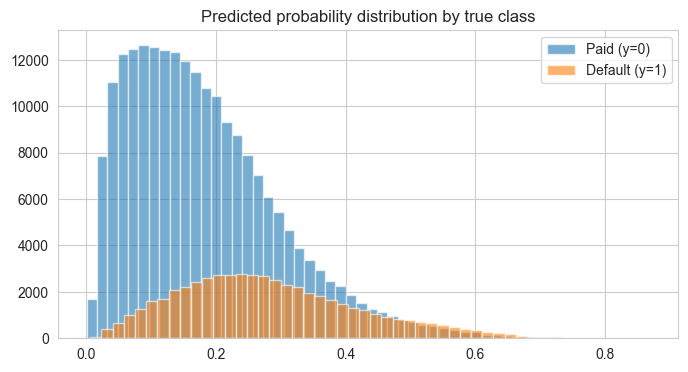

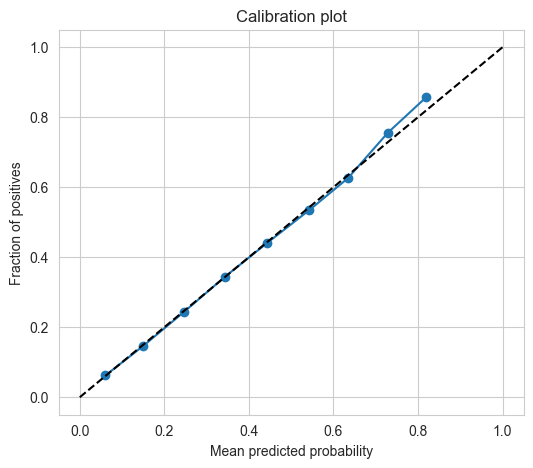

Saved ROC/PR figures to ..\models\figures


In [39]:
# Task4_Cell4 - plots (ROC, PR, probability histograms, calibration)
fpr, tpr, _ = roc_curve(y_test, test_preds)
precision, recall, _ = precision_recall_curve(y_test, test_preds)
prob_true, prob_pred = calibration_curve(y_test, test_preds, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,label=f"AUC={test_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(test_preds[y_test==0], bins=50, alpha=0.6, label="Paid (y=0)")
plt.hist(test_preds[y_test==1], bins=50, alpha=0.6, label="Default (y=1)")
plt.legend(); plt.title("Predicted probability distribution by true class"); plt.show()

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives"); plt.title("Calibration plot")
plt.show()

# Save figures for report
fig_dir = os.path.join(MODELS_DIR, "figures")
os.makedirs(fig_dir, exist_ok=True)
plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'k--'); plt.title("ROC"); plt.savefig(os.path.join(fig_dir,"roc_curve.png")); plt.close()
plt.figure(); plt.plot(recall, precision); plt.title("PR"); plt.savefig(os.path.join(fig_dir,"pr_curve.png")); plt.close()
print("Saved ROC/PR figures to", fig_dir)


In [40]:
# Task4_Cell5 - policy values, approval rates, mean reward per approved loan
sup_actions = (test_preds >= best_thr).astype(int)
rl_actions = np.array(rl_actions).astype(int).ravel()

approve_rates = {
    "RL": float(rl_actions.mean()),
    "Supervised": float(sup_actions.mean()),
    "Approve-all": 1.0,
    "Deny-all": 0.0
}
print("Approval rates (fraction):", approve_rates)

loan_amnt_test = loan_amnt[test_idx]
int_rate_test = int_rate[test_idx]

rl_rewards = np.where(rl_actions==1, np.where(y_test==0, loan_amnt_test*int_rate_test, -loan_amnt_test), 0.0)
sup_rewards = np.where(sup_actions==1, np.where(y_test==0, loan_amnt_test*int_rate_test, -loan_amnt_test), 0.0)

def mean_reward_per_approved(actions, rewards):
    mask = actions==1
    if mask.sum()==0:
        return 0.0
    return rewards[mask].mean()

print("Avg reward per applicant -> RL:", rl_rewards.mean(), " Supervised:", sup_rewards.mean())
print("Avg reward per approved loan -> RL:", mean_reward_per_approved(rl_actions, rl_rewards),
      " Supervised:", mean_reward_per_approved(sup_actions, sup_rewards))


Approval rates (fraction): {'RL': 0.8009938229850369, 'Supervised': 0.3537734797184292, 'Approve-all': 1.0, 'Deny-all': 0.0}
Avg reward per applicant -> RL: -1604.3741  Supervised: -1395.7191
Avg reward per approved loan -> RL: -2002.9795  Supervised: -3945.234


In [41]:
# Task4_Cell6 - disagreements examples & save
# Build comparison DataFrame if not present
if 'comparison_df' not in globals():
    comparison_df = pd.DataFrame({
        "test_idx": test_idx,
        "prob_supervised": test_preds,
        "sup_action": sup_actions,
        "rl_action": rl_actions,
        "y": y_test,
        "loan_amnt": loan_amnt_test,
        "int_rate": int_rate_test
    })
    comparison_df["rl_reward"] = np.where(comparison_df["rl_action"]==1,
                                          np.where(comparison_df["y"]==0, comparison_df["loan_amnt"]*comparison_df["int_rate"], -comparison_df["loan_amnt"]), 0.0)
    comparison_df["sup_reward"] = np.where(comparison_df["sup_action"]==1,
                                           np.where(comparison_df["y"]==0, comparison_df["loan_amnt"]*comparison_df["int_rate"], -comparison_df["loan_amnt"]), 0.0)
    joblib.dump(comparison_df, os.path.join(MODELS_DIR,"rl_vs_supervised_comparison.joblib"))

diffs = comparison_df[comparison_df["sup_action"] != comparison_df["rl_action"]].copy()
print("Total disagreements on test:", len(diffs))

# Save top disagreement examples for report (both types)
diffs.to_csv(os.path.join(MODELS_DIR,"rl_supervised_disagreements_all.csv"), index=False)
diffs.head(50).to_csv(os.path.join(MODELS_DIR,"rl_supervised_disagreements_sample.csv"), index=False)
print("Saved all disagreements and a sample to", MODELS_DIR)

# Show examples: (1) RL approves but sup denies and large negative reward
bad_rl = diffs[(diffs["rl_action"]==1) & (diffs["y"]==1)].sort_values("rl_reward").head(10)
print("\nExamples where RL approved but borrower defaulted (harmful approvals):")
display(bad_rl)

# (2) sup approves but rl denies (cases RL is conservative)
sup_approve_rl_deny = diffs[(diffs["sup_action"]==1) & (diffs["rl_action"]==0)].head(10)
print("\nExamples where Supervised approves but RL denies:")
display(sup_approve_rl_deny)


Total disagreements on test: 124916
Saved all disagreements and a sample to ..\models

Examples where RL approved but borrower defaulted (harmful approvals):


,test_idx,prob_supervised,sup_action,rl_action,y,loan_amnt,int_rate,rl_reward,sup_reward
17536,569320,0.102504,0,1,1,40000.0,0.1199,-40000.0,0.0
172666,481222,0.190390,0,1,1,40000.0,0.1299,-40000.0,0.0
17118,388961,0.213599,0,1,1,40000.0,0.1602,-40000.0,0.0
61191,471621,0.169833,0,1,1,40000.0,0.0975,-40000.0,0.0
242265,463121,0.095050,0,1,1,40000.0,0.1199,-40000.0,0.0
139688,432893,0.163553,0,1,1,40000.0,0.1602,-40000.0,0.0
136634,901152,0.203044,0,1,1,40000.0,0.1213,-40000.0,0.0
136653,501259,0.137867,0,1,1,40000.0,0.0975,-40000.0,0.0
83788,1299737,0.086218,0,1,1,40000.0,0.0799,-40000.0,0.0
245856,967382,0.062485,0,1,1,40000.0,0.0824,-40000.0,0.0



Examples where Supervised approves but RL denies:


,test_idx,prob_supervised,sup_action,rl_action,y,loan_amnt,int_rate,rl_reward,sup_reward
9,803292,0.295059,1,0,0,14400.0,0.1167,0.0,1680.479980
43,366259,0.232293,1,0,0,5000.0,0.1239,0.0,619.500000
114,233829,0.265184,1,0,0,5950.0,0.1561,0.0,928.795044
193,1255510,0.287387,1,0,1,10000.0,0.0944,0.0,-10000.000000
319,1061076,0.242632,1,0,1,9950.0,0.1235,0.0,-9950.000000
686,818027,0.330821,1,0,1,14000.0,0.1335,0.0,-14000.000000
731,610603,0.313995,1,0,0,15000.0,0.1075,0.0,1612.500000
830,76036,0.349526,1,0,0,16000.0,0.1399,0.0,2238.399902
929,895797,0.239866,1,0,0,40000.0,0.1072,0.0,4288.000000
1083,908087,0.260401,1,0,0,20000.0,0.1105,0.0,2210.000000


In [42]:
# Task4_Cell7 - threshold search by expected reward (val if present else test)
val_preds = globals().get("val_preds", None)
if val_preds is not None and 'val_idx' in globals():
    preds_for_search = val_preds
    y_for_search = y[val_idx]
    la_for_search = loan_amnt[val_idx]
    ir_for_search = int_rate[val_idx]
    source = "validation"
else:
    preds_for_search = test_preds
    y_for_search = y_test
    la_for_search = loan_amnt_test
    ir_for_search = int_rate_test
    source = "test (proxy)"

thr_grid = np.linspace(0.01, 0.5, 100)
best_thr_by_value = None
best_val = -1e18
for thr in thr_grid:
    actions = (preds_for_search >= thr).astype(int)
    rew = np.where(actions==1, np.where(y_for_search==0, la_for_search*ir_for_search, -la_for_search), 0.0)
    mean_val = rew.mean()
    if mean_val > best_val:
        best_val = mean_val
        best_thr_by_value = thr

print(f"Best threshold on {source} by expected reward: {best_thr_by_value:.3f} (mean reward: {best_val:.4f})")
# show how this best threshold would compare on test
sup_actions_best = (test_preds >= best_thr_by_value).astype(int)
sup_rewards_best = np.where(sup_actions_best==1, np.where(y_test==0, loan_amnt_test*int_rate_test, -loan_amnt_test), 0.0)
print("Test performance at this threshold: mean reward:", sup_rewards_best.mean(), "approve rate:", sup_actions_best.mean())
# Save chosen threshold
joblib.dump({"best_thr_by_value": float(best_thr_by_value), "best_val": float(best_val)}, os.path.join(MODELS_DIR,"best_threshold_by_value.joblib"))
print("Saved best threshold by value to", os.path.join(MODELS_DIR,"best_threshold_by_value.joblib"))


Best threshold on test (proxy) by expected reward: 0.500 (mean reward: -260.6471)
Test performance at this threshold: mean reward: -260.64706 approve rate: 0.02936497907545473
Saved best threshold by value to ..\models\best_threshold_by_value.joblib
